In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.visualization import ImageNormalize, SqrtStretch, ZScaleInterval
import sunpy
import sunpy.map
aia_193_cm = plt.get_cmap("sdoaia193")
import juanfit
from juanfit import SpectrumFit2D, gaussian
import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, FixedLocator, 
                               FixedFormatter, LogLocator, StrMethodFormatter, MaxNLocator)
import scipy.optimize
from scipy.io import readsav
from scipy import interpolate
import skimage
import pandas as pd

In [2]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14,
                  bbox_to_anchor=(1.02, 0., 1, 1)):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=bbox_to_anchor,
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [3]:
# with fits.open("../../src/CoMP/new_l2/20170821.comp.1074.l2/20170821.comp.1074.quick_invert.median.synoptic.fts.gz") as hdul:
#     hdul.info()
#     header_1074 = hdul[0].header
#     intensity_1074 = np.copy(hdul[4].data)

with fits.open("../../src/CoMP/new_l2/20170821.comp.1074.l2/20170821.174607.comp.1074.dynamics.fts.gz") as hdul:
    hdul.info()
    header_1074 = hdul[0].header
    intensity_1074 = np.copy(hdul[1].data)
    enintensity_1074 = np.copy(hdul[2].data)

comp_nx, comp_ny = 620, 620
comp_xcoord = np.linspace(1 - header_1074["CRPIX1"], comp_nx - header_1074["CRPIX1"], comp_nx)*header_1074["CDELT1"]
comp_ycoord = np.linspace(1 - header_1074["CRPIX2"], comp_nx - header_1074["CRPIX2"], comp_ny)*header_1074["CDELT2"]

Filename: ../../src/CoMP/new_l2/20170821.comp.1074.l2/20170821.174607.comp.1074.dynamics.fts.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      84   ()      
  1  Intensity     1 ImageHDU        38   (620, 620)   float32   
  2  Enhanced Intensity    1 ImageHDU        38   (620, 620)   uint8   
  3  Corrected LOS velocity    1 ImageHDU        39   (620, 620)   float32   
  4  Line Width    1 ImageHDU        38   (620, 620)   float32   


In [4]:
header_1074["CDELT1"], header_1074["CRPIX1"]

(4.35, 310.5)

In [5]:
# with fits.open("../../src/CoMP/new_l2/20170821.comp.1079.l2/20170821.comp.1079.quick_invert.median.synoptic.fts.gz") as hdul:
#     hdul.info()
#     header_1079 = hdul[0].header
#     intensity_1079 = np.copy(hdul[4].data)

with fits.open("../../src/CoMP/new_l2/20170821.comp.1079.l2/20170821.174303.comp.1079.dynamics.fts.gz") as hdul:
    hdul.info()
    header_1079 = hdul[0].header
    intensity_1079 = np.copy(hdul[1].data)
    enintensity_1079 = np.copy(hdul[2].data)

Filename: ../../src/CoMP/new_l2/20170821.comp.1079.l2/20170821.174303.comp.1079.dynamics.fts.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      84   ()      
  1  Intensity     1 ImageHDU        38   (620, 620)   float32   
  2  Enhanced Intensity    1 ImageHDU        38   (620, 620)   uint8   
  3  Corrected LOS velocity    1 ImageHDU        39   (620, 620)   float32   
  4  Line Width    1 ImageHDU        38   (620, 620)   float32   


In [6]:
intensity_1074_mean_grid = np.full((comp_nx, comp_ny, 5), np.nan)
with fits.open("../../src/CoMP/new_l2/20170821.comp.1074.l2/20170821.comp.1074.mean.synoptic.fts.gz") as hdul:
    hdul.info()
    for ii in range(5):
        intensity_1074_mean_grid[:,:,ii] = np.copy(hdul[ii+1].data)
# hdul[0].header
wvl_1074_grid = np.array([1074.38, 1074.50, 1074.62, 1074.74, 1074.86])

Filename: ../../src/CoMP/new_l2/20170821.comp.1074.l2/20170821.comp.1074.mean.synoptic.fts.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      90   ()      
  1  I, 1074.38    1 ImageHDU        56   (620, 620)   float32   
  2  I, 1074.50    1 ImageHDU        56   (620, 620)   float32   
  3  I, 1074.62    1 ImageHDU        56   (620, 620)   float32   
  4  I, 1074.74    1 ImageHDU        56   (620, 620)   float32   
  5  I, 1074.86    1 ImageHDU        56   (620, 620)   float32   
  6  Q, 1074.38    1 ImageHDU        56   (620, 620)   float32   
  7  Q, 1074.50    1 ImageHDU        56   (620, 620)   float32   
  8  Q, 1074.62    1 ImageHDU        56   (620, 620)   float32   
  9  Q, 1074.74    1 ImageHDU        56   (620, 620)   float32   
 10  Q, 1074.86    1 ImageHDU        56   (620, 620)   float32   
 11  U, 1074.38    1 ImageHDU        56   (620, 620)   float32   
 12  U, 1074.50    1 ImageHDU        56   (620, 620)   float32   
 

In [7]:
intensity_1079_mean_grid = np.full((comp_nx, comp_ny, 5), np.nan)
with fits.open("../../src/CoMP/new_l2/20170821.comp.1079.l2/20170821.comp.1079.mean.synoptic.fts.gz") as hdul:
    hdul.info()
    for ii in range(5):
        intensity_1079_mean_grid[:,:,ii] = np.copy(hdul[ii+1].data)
# hdul[0].header
wvl_1079_grid = np.array([1079.54, 1079.66, 1079.78, 1079.90, 1080.02])

Filename: ../../src/CoMP/new_l2/20170821.comp.1079.l2/20170821.comp.1079.mean.synoptic.fts.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      90   ()      
  1  I, 1079.54    1 ImageHDU        56   (620, 620)   float32   
  2  I, 1079.66    1 ImageHDU        56   (620, 620)   float32   
  3  I, 1079.78    1 ImageHDU        56   (620, 620)   float32   
  4  I, 1079.90    1 ImageHDU        56   (620, 620)   float32   
  5  I, 1080.02    1 ImageHDU        56   (620, 620)   float32   
  6  Q, 1079.54    1 ImageHDU        56   (620, 620)   float32   
  7  Q, 1079.66    1 ImageHDU        56   (620, 620)   float32   
  8  Q, 1079.78    1 ImageHDU        56   (620, 620)   float32   
  9  Q, 1079.90    1 ImageHDU        56   (620, 620)   float32   
 10  Q, 1080.02    1 ImageHDU        56   (620, 620)   float32   
 11  U, 1079.54    1 ImageHDU        56   (620, 620)   float32   
 12  U, 1079.66    1 ImageHDU        56   (620, 620)   float32   
 

In [8]:
FeXIII_1074_fitmodel = SpectrumFit2D(data=intensity_1074_mean_grid[:,:310,:], wvl=wvl_1074_grid,
                                     custom_func=gaussian,custom_init=[1074.6,0.1,0.2])
FeXIII_1074_fitmodel_3point = SpectrumFit2D(data=intensity_1074_mean_grid[:,:310,1:4], wvl=wvl_1074_grid[1:4],
                                     custom_func=gaussian,custom_init=[1074.6,0.1,0.2])

# FeXIII_1074_fitmodel = SpectrumFit2D(data=intensity_1074_mean_grid[:,:310,:], wvl=wvl_1074_grid,
#                                      line_number=1,line_wvl_init=1074.6,int_max_init=1,fwhm_init=0.2)
FeXIII_1074_fitmodel.run_lse_mp(ncpu="max",prev_init=False)
FeXIII_1074_fitmodel_3point.run_lse_mp(ncpu="max",prev_init=False)

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn(

/Users/yjzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/yjzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


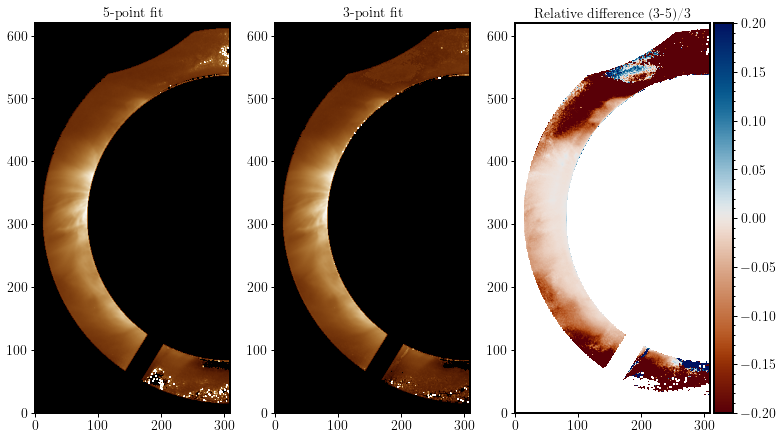

In [9]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,6),constrained_layout=True)

norm_1074_mean = ImageNormalize(FeXIII_1074_fitmodel.custom_fit[:,:,1],stretch=SqrtStretch(),vmin=0,vmax=2)
im1 = ax1.imshow(FeXIII_1074_fitmodel.custom_fit[:,:,1],origin="lower",norm=norm_1074_mean,cmap=aia_193_cm)
ax1.set_title("5-point fit",fontsize=14)

im2 = ax2.imshow(FeXIII_1074_fitmodel_3point.custom_fit[:,:,1],origin="lower",norm=norm_1074_mean,cmap=aia_193_cm)
ax2.set_title("3-point fit",fontsize=14)

im3 = ax3.imshow((FeXIII_1074_fitmodel_3point.custom_fit[:,:,1] - FeXIII_1074_fitmodel.custom_fit[:,:,1])/FeXIII_1074_fitmodel_3point.custom_fit[:,:,1]
           ,origin="lower",vmin=-0.2,vmax=0.2,cmap=cmcm.vik_r)
ax3.set_title("Relative difference (3-5)/3",fontsize=14)

plot_colorbar(im3,ax3,width="10%")

for ax_ in (ax1,ax2,ax3):
    ax_.tick_params(labelsize=14)

In [10]:
FeXIII_1079_fitmodel = SpectrumFit2D(data=intensity_1079_mean_grid[:,:310,:], wvl=wvl_1079_grid,
                                     custom_func=gaussian,custom_init=[1079.8,0.03,0.2])
FeXIII_1079_fitmodel_3point = SpectrumFit2D(data=intensity_1079_mean_grid[:,:310,1:4], wvl=wvl_1079_grid[1:4],
                                     custom_func=gaussian,custom_init=[1079.8,0.03,0.2])

# FeXIII_1079_fitmodel = SpectrumFit2D(data=intensity_1079_mean_grid[:,:310,:], wvl=wvl_1079_grid,
#                                      line_number=1,line_wvl_init=1079.6,int_max_init=1,fwhm_init=0.2)
FeXIII_1079_fitmodel.run_lse_mp(ncpu="max",prev_init=False)
FeXIII_1079_fitmodel_3point.run_lse_mp(ncpu="max",prev_init=False)

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:296: RuntimeWarning: invalid value encountered in sqrt
  self.custom_err = np.sqrt(np.diagonal(pcov))
/Users/yjzhu/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/yjzhu/Desktop/Solar/MyPy

/Users/yjzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/yjzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


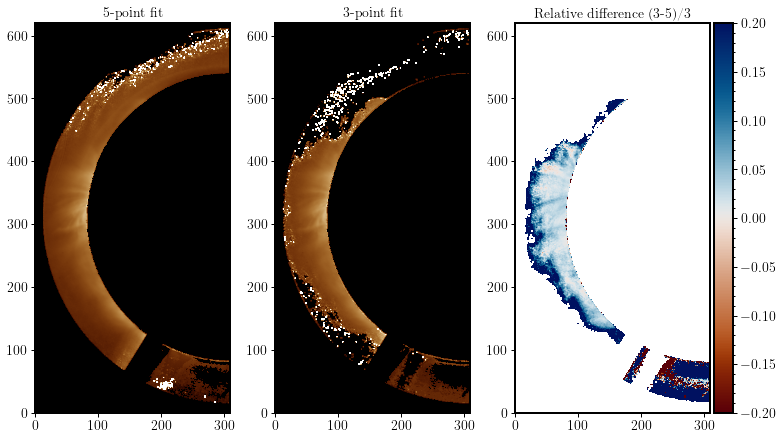

In [11]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,6),constrained_layout=True)

norm_1079_mean = ImageNormalize(FeXIII_1079_fitmodel.custom_fit[:,:,1],stretch=SqrtStretch(),vmin=0,vmax=2)
im1 = ax1.imshow(FeXIII_1079_fitmodel.custom_fit[:,:,1],origin="lower",norm=norm_1079_mean,cmap=aia_193_cm)
ax1.set_title("5-point fit",fontsize=14)

im2 = ax2.imshow(FeXIII_1079_fitmodel_3point.custom_fit[:,:,1],origin="lower",norm=norm_1079_mean,cmap=aia_193_cm)
ax2.set_title("3-point fit",fontsize=14)

im3 = ax3.imshow((FeXIII_1079_fitmodel_3point.custom_fit[:,:,1] - FeXIII_1079_fitmodel.custom_fit[:,:,1])/FeXIII_1079_fitmodel_3point.custom_fit[:,:,1]
           ,origin="lower",vmin=-0.2,vmax=0.2,cmap=cmcm.vik_r)
ax3.set_title("Relative difference (3-5)/3",fontsize=14)

plot_colorbar(im3,ax3,width="10%")

for ax_ in (ax1,ax2,ax3):
    ax_.tick_params(labelsize=14)

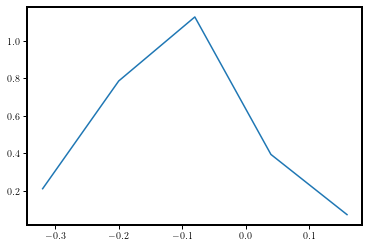

In [12]:
plt.plot(wvl_1074_grid-1074.7, intensity_1074_mean_grid[300,40,:])

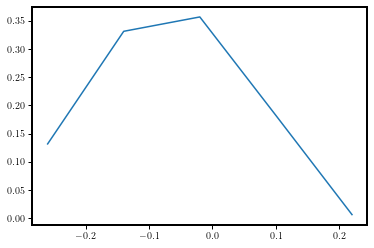

In [13]:
plt.plot(wvl_1079_grid-1079.8, intensity_1079_mean_grid[300,40,:])

In [14]:
FeXIII_ratio_sav = readsav("../../sav/CoMP/FeXIII_1074_1079_ratio.sav",verbose=True)
chianti_dens = FeXIII_ratio_sav["dens"]
chianti_height = FeXIII_ratio_sav["height"]
FeXIII_ratio = FeXIII_ratio_sav["fexiii_1074_1079_ratio"]

chianti_dens_mesh, chianti_height_mesh = np.meshgrid(chianti_dens, chianti_height)

--------------------------------------------------
Date: Wed Jun 21 12:16:46 2023
User: yjzhu
Host: 0587459236.wireless.umich.net
--------------------------------------------------
Format: 11
Architecture: x86_64
Operating System: darwin
IDL Version: 8.2
--------------------------------------------------
Successfully read 7 records of which:
 - 1 are of type VERSION
 - 4 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - fexiii_1074_1079_ratio [<class 'numpy.ndarray'>]
 - dens [<class 'numpy.ndarray'>]
 - height [<class 'numpy.ndarray'>]
 - temp [<class 'numpy.float32'>]
--------------------------------------------------


/Users/yjzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/yjzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


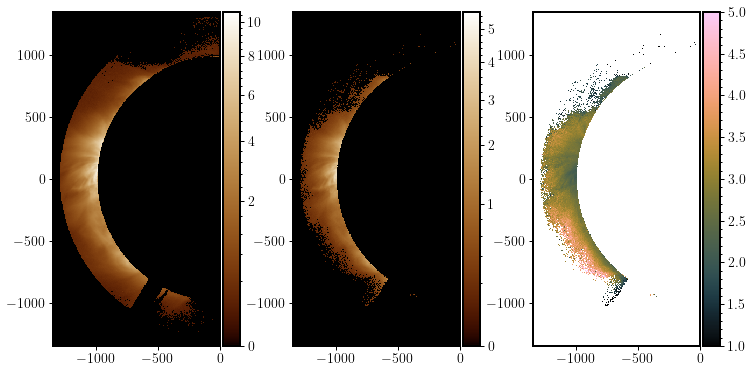

In [15]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,5),constrained_layout=True)

norm_1074 = ImageNormalize(data=intensity_1074,stretch=SqrtStretch())
im1 = ax1.pcolormesh(comp_xcoord, comp_ycoord, intensity_1074, cmap=aia_193_cm, norm=norm_1074)
plot_colorbar(im1, ax1, width="10%")

norm_1079 = ImageNormalize(data=intensity_1079,stretch=SqrtStretch())
im2 = ax2.pcolormesh(comp_xcoord, comp_ycoord, intensity_1079, cmap=aia_193_cm, norm=norm_1079)
plot_colorbar(im2, ax2, width="10%")

im3 = ax3.pcolormesh(comp_xcoord, comp_ycoord, intensity_1074/intensity_1079, cmap=cmcm.batlowK, vmin=1,vmax=5)
plot_colorbar(im3, ax3, width="10%")

for ax_ in (ax1,ax2,ax3):
    ax_.set_aspect("equal")
    ax_.set_xlim(right=0)
    ax_.tick_params(labelsize=14)

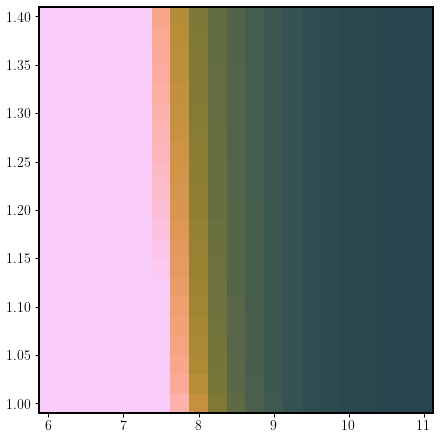

In [16]:
fig, ax = plt.subplots(figsize=(6,6),constrained_layout=True)

ax.pcolormesh(chianti_dens_mesh, chianti_height_mesh, FeXIII_ratio, cmap=cmcm.batlowK, vmin=0,vmax=5)
ax.tick_params(labelsize=14)

In [17]:
def FeXIII_ratio_func(height, ratio):
    FeXIII_height_func = interpolate.interp1d(chianti_height, FeXIII_ratio, axis=0, bounds_error=False)
    FeXIII_ratio_at_height = FeXIII_height_func(height)

    FeXIII_dens_func = interpolate.interp1d(FeXIII_ratio_at_height, chianti_dens, bounds_error=False)
    FeXIII_dens_measured = FeXIII_dens_func(ratio)
    
    return FeXIII_dens_measured

In [18]:
comp_xmesh, comp_ymesh = np.meshgrid(comp_xcoord, comp_ycoord)
comp_height_mesh = np.sqrt(comp_xmesh**2 + comp_ymesh**2)/header_1074["RSUN"]

In [19]:
FeXIII_dens_1074_1079 = np.full((comp_nx,comp_ny),np.nan)
for ii in range(620):
    for jj in range(620):
        FeXIII_dens_1074_1079[ii,jj] = FeXIII_ratio_func(comp_height_mesh[ii,jj], intensity_1074[ii,jj]/intensity_1079[ii,jj])
        


/Users/yjzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in float_scalars
  after removing the cwd from sys.path.
/Users/yjzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in float_scalars
  after removing the cwd from sys.path.


In [20]:
FeXIII_dens_1074_1079_mean = np.full((comp_ny,int(comp_nx/2)),np.nan)
for ii in range(620):
    for jj in range(310):
        FeXIII_dens_1074_1079_mean[ii,jj] = FeXIII_ratio_func(comp_height_mesh[ii,jj], 
                                                         FeXIII_1074_fitmodel.custom_fit[ii,jj,1]/FeXIII_1079_fitmodel.custom_fit[ii,jj,1])
        


/Users/yjzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/Users/yjzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


/Users/yjzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/yjzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


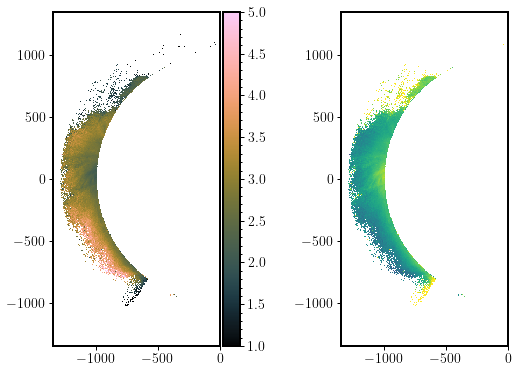

In [21]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,5),constrained_layout=True)


im1 = ax1.pcolormesh(comp_xcoord, comp_ycoord, intensity_1074/intensity_1079, cmap=cmcm.batlowK, vmin=1,vmax=5)
plot_colorbar(im1, ax1, width="10%")

ax2.pcolormesh(comp_xcoord[:310],comp_ycoord,FeXIII_dens_1074_1079[:,:310],vmin=7,vmax=8.5)


for ax_ in (ax1,ax2):
    ax_.set_aspect("equal")
    ax_.set_xlim(right=0)
    ax_.tick_params(labelsize=14)

In [22]:
def find_nearest_pixel(x,y,x_grid,y_grid):
    distance = np.sqrt((x - x_grid)**2 + (y - y_grid)**2)
    index = np.unravel_index(np.argmin(distance),distance.shape)
    return index

In [23]:
def get_select_pixel_index(node_solarx, node_solary,xgrid,ygrid):
    node_xpixel, node_ypixel = np.zeros_like(node_solarx), np.zeros_like(node_solary)

    for ii in range(len(node_solarx)):
        node_ypixel[ii],node_xpixel[ii] = find_nearest_pixel(node_solarx[ii],node_solary[ii], 
            xgrid,ygrid)
    
    select_pixels_xindex = []
    select_pixels_yindex = []

    for ii in range(len(node_xpixel) - 1):
        rr, cc = skimage.draw.line(node_ypixel[ii],node_xpixel[ii],
                                node_ypixel[ii+1],node_xpixel[ii+1])
        
        select_pixels_xindex = np.concatenate((select_pixels_xindex,cc))
        select_pixels_yindex = np.concatenate((select_pixels_yindex,rr))

        index_tuple = tuple(np.stack((select_pixels_yindex,select_pixels_xindex),axis=-1).astype(np.int32).T)
        select_solarx = xgrid[index_tuple]
        select_solary = ygrid[index_tuple]
    
    return index_tuple, select_solarx, select_solary

In [24]:
AR_cut_index_1, AR_cut_solarx_1, AR_cut_solary_1 = \
                        get_select_pixel_index([-937,-1051,-1250],[266,291,280],
                        comp_xmesh,comp_ymesh)

AR_cut_delete_index_1 = np.where(np.sqrt(AR_cut_solarx_1**2 + AR_cut_solary_1**2)/header_1074["RSUN"] < 1.06)
AR_cut_solarx_1 = np.delete(AR_cut_solarx_1,AR_cut_delete_index_1)
AR_cut_solary_1 = np.delete(AR_cut_solary_1,AR_cut_delete_index_1)

AR_cut_index_2, AR_cut_solarx_2, AR_cut_solary_2 = \
                        get_select_pixel_index([-975,-1250],[40,-65],
                        comp_xmesh,comp_ymesh)
AR_cut_delete_index_2 = np.where(np.sqrt(AR_cut_solarx_2**2 + AR_cut_solary_2**2)/header_1074["RSUN"] < 1.06)
AR_cut_solarx_2 = np.delete(AR_cut_solarx_2,AR_cut_delete_index_2)
AR_cut_solary_2 = np.delete(AR_cut_solary_2,AR_cut_delete_index_2)

ST_cut_index_1, ST_cut_solarx_1, ST_cut_solary_1 = \
                        get_select_pixel_index([-700,-987],[-700,-707],
                        comp_xmesh,comp_ymesh)
ST_cut_delete_index_1 = np.where(np.sqrt(ST_cut_solarx_1**2 + ST_cut_solary_1**2)/header_1074["RSUN"] < 1.06)
ST_cut_solarx_1 = np.delete(ST_cut_solarx_1,ST_cut_delete_index_1)
ST_cut_solary_1 = np.delete(ST_cut_solary_1,ST_cut_delete_index_1)

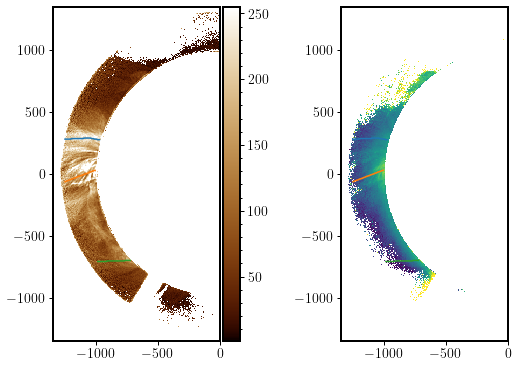

In [25]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,5),constrained_layout=True)

enintensity_1074 = enintensity_1074.astype(np.float64)
enintensity_1074[enintensity_1074 <= 0] = np.nan

im1 = ax1.pcolormesh(comp_xcoord, comp_ycoord, enintensity_1074, cmap=aia_193_cm, 
                     norm=ImageNormalize(enintensity_1074))

plot_colorbar(im1, ax1, width="10%")



ax2.pcolormesh(comp_xcoord[:310],comp_ycoord,FeXIII_dens_1074_1079[:,:310],vmin=7.5,vmax=8.5)


for ax_ in (ax1,ax2):
    ax_.plot(AR_cut_solarx_1, AR_cut_solary_1)
    ax_.plot(AR_cut_solarx_2, AR_cut_solary_2)
    ax_.plot(ST_cut_solarx_1, ST_cut_solary_1)
    ax_.set_aspect("equal")
    ax_.set_xlim(right=0)
    ax_.tick_params(labelsize=14)

In [26]:
AR_density_1 = FeXIII_dens_1074_1079[AR_cut_index_1]
AR_density_1 = np.delete(AR_density_1,AR_cut_delete_index_1)
AR_density_1_good_index = np.isfinite(AR_density_1)
AR_density_1 = AR_density_1[AR_density_1_good_index]
AR_cut_solarx_1 = AR_cut_solarx_1[AR_density_1_good_index]
AR_cut_solary_1 = AR_cut_solary_1[AR_density_1_good_index]

AR_density_2 = FeXIII_dens_1074_1079[AR_cut_index_2]
AR_density_2 = np.delete(AR_density_2,AR_cut_delete_index_2)
AR_density_2_good_index = np.isfinite(AR_density_2)
AR_density_2 = AR_density_2[AR_density_2_good_index]
AR_cut_solarx_2 = AR_cut_solarx_2[AR_density_2_good_index]
AR_cut_solary_2 = AR_cut_solary_2[AR_density_2_good_index]

ST_density_1 = FeXIII_dens_1074_1079[ST_cut_index_1]
ST_density_1 = np.delete(ST_density_1,ST_cut_delete_index_1)
ST_density_1_good_index = np.isfinite(ST_density_1)
ST_density_1 = ST_density_1[ST_density_1_good_index]
ST_cut_solarx_1 = ST_cut_solarx_1[ST_density_1_good_index]
ST_cut_solary_1 = ST_cut_solary_1[ST_density_1_good_index]

In [27]:
def find_median_values(window_center,window_width,height,dens):
    median_dens = []
    for wc_, ww_ in zip(window_center,window_width):
        dens_window = dens[(height >= wc_ - ww_/2) & (height <= wc_ + ww_/2)]
        median_dens.append(np.nanmedian(dens_window))   
    return np.array(median_dens)

In [28]:
AR_density_1_median = find_median_values([1.1,1.2,1.3],[0.1,0.1,0.1],np.sqrt(AR_cut_solarx_1**2 + AR_cut_solary_1**2)/header_1074["RSUN"],
                                         AR_density_1)
AR_density_2_median = find_median_values([1.1,1.2,1.3],[0.1,0.1,0.1],np.sqrt(AR_cut_solarx_2**2 + AR_cut_solary_2**2)/header_1074["RSUN"],
                                            AR_density_2)
ST_density_1_median = find_median_values([1.1,1.2,1.25],[0.1,0.1,0.1],np.sqrt(ST_cut_solarx_1**2 + ST_cut_solary_1**2)/header_1074["RSUN"],
                                            ST_density_1)

In [29]:
print(AR_density_1_median,AR_density_2_median,ST_density_1_median)

[7.9659716  7.80338094 7.71524594] [8.11556169 7.90052095 7.73870596] [7.85758346 7.63687485 7.51933149]


In [30]:
pop_processes_df = pd.read_excel("../../sav/CoMP/pop_processes_FeXIV.xlsx")
pop_processes_df

,region,rphot,dens,rd,e,p,ph
0,AR11,1.10,8.10,54.64,18.83,7.61,18.92
1,AR13,1.30,7.70,48.60,17.33,7.00,27.07
2,AR15,1.50,7.30,39.86,14.42,5.83,39.90
3,ST1,1.10,7.85,47.10,16.58,6.70,29.63
4,ST12,1.25,7.50,40.19,14.42,5.83,39.56
5,ST15,1.50,7.00,28.45,10.33,4.17,57.05


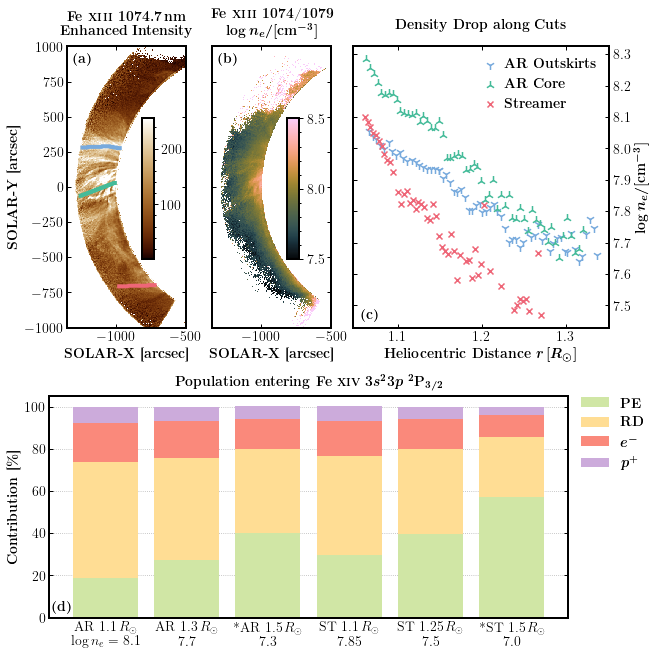

In [31]:
# stackbar_groups = [r"AR 1.1\,$R_\odot$" + "\n" + r"$\log n_e = 8.1$",
#                    r"AR 1.3\,$R_\odot$" + "\n" + r"$\log n_e = 7.7$",
#                    r"*AR 1.5\,$R_\odot$" + "\n" + r"$\log n_e = 7.3$",
#                    r"ST 1.1\,$R_\odot$" + "\n" + r"$\log n_e = 7.85$",
#                    r"ST 1.25\,$R_\odot$" + "\n" + r"$\log n_e = 7.5$",
#                    r"*ST 1.5\,$R_\odot$" + "\n" + r"$\log n_e = 7.0$"]

stackbar_groups = [r"AR 1.1\,$R_\odot$" + "\n" + r"$\log n_e = 8.1$",
                   r"AR 1.3\,$R_\odot$" + "\n" + r"$7.7$",
                   r"*AR 1.5\,$R_\odot$" + "\n" + r"$7.3$",
                   r"ST 1.1\,$R_\odot$" + "\n" + r"$7.85$",
                   r"ST 1.25\,$R_\odot$" + "\n" + r"$7.5$",
                   r"*ST 1.5\,$R_\odot$" + "\n" + r"$7.0$"]

stackbar_colors = ["#D0E6A5","#FFDD94","#FA897B","#CCABDB"]

fig = plt.figure(figsize=(9,9),constrained_layout=True)
subfigs = fig.subfigures(2,1,height_ratios=[9,7])
ax1,ax2,ax3 = subfigs[0].subplots(1,3,gridspec_kw={"width_ratios":[1,1,2]})
ax4 = subfigs[1].subplots()

im1 = ax1.pcolormesh(comp_xcoord, comp_ycoord, enintensity_1074, cmap=aia_193_cm, 
                     norm=ImageNormalize(enintensity_1074),rasterized=True)
ax1.set_title(r"\textbf{Fe \textsc{xiii} 1074.7\,nm}" + "\n" + r"\textbf{Enhanced Intensity}",fontsize=14,
              y=1.02)
ax1.set_ylabel(r"\textbf{SOLAR-Y [arcsec]}",fontsize=14)
ax1.set_xlabel(r"\textbf{SOLAR-X [arcsec]}",fontsize=14)

ax1.plot(AR_cut_solarx_1, AR_cut_solary_1, color="#77AADD",lw=4)
ax1.plot(AR_cut_solarx_2, AR_cut_solary_2, color="#44BB99",lw=4)
ax1.plot(ST_cut_solarx_1, ST_cut_solary_1, color="#EE6677",lw=4)

clb1, clb_ax1 = plot_colorbar(im1,ax1,width="10%",bbox_to_anchor=(0.63, -0.48, 1, 0.9))
clb_ax1.yaxis.set_major_locator(MaxNLocator(2))

ax1.text(0.05,0.98,r"\textbf{(a)}",fontsize=14,transform=ax1.transAxes,ha="left",va="top")

im2 = ax2.pcolormesh(comp_xcoord[:310],comp_ycoord,FeXIII_dens_1074_1079[:,:310],vmin=7.5,vmax=8.5,
                     cmap=cmcm.batlowK,rasterized=True)
ax2.set_xlabel(r"\textbf{SOLAR-X [arcsec]}",fontsize=14)
ax2.set_title(r"\textbf{Fe \textsc{xiii} 1074/1079}" "\n" + r"$\boldsymbol{\log n_e/\mathrm{[cm^{-3}]}}$",fontsize=14,
              y=1.02)
ax2.tick_params(labelleft=False)
clb2, clb_ax2 = plot_colorbar(im2,ax2,width="10%",bbox_to_anchor=(0.63, -0.48, 1, 0.9))
clb_ax2.yaxis.set_major_locator(MaxNLocator(2))

ax2.text(0.05,0.98,r"\textbf{(b)}",fontsize=14,transform=ax2.transAxes,ha="left",va="top")

ax3.scatter(np.sqrt(AR_cut_solarx_1**2 + AR_cut_solary_1**2)/header_1074["RSUN"],AR_density_1,label=r"\textbf{AR Outskirts}",
            color="#77AADD",marker="1",s=80)
ax3.scatter(np.sqrt(AR_cut_solarx_2**2 + AR_cut_solary_2**2)/header_1074["RSUN"],AR_density_2,label=r"\textbf{AR Core}",
            color="#44BB99",marker="2",s=80)
ax3.scatter(np.sqrt(ST_cut_solarx_1**2 + ST_cut_solary_1**2)/header_1074["RSUN"],ST_density_1,label=r"\textbf{Streamer}",
            color="#EE6677",marker="x")

ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel(r"$\boldsymbol{\log n_e/\mathrm{[cm^{-3}]}}$",fontsize=14,)
ax3.set_xlabel(r"\textbf{Heliocentric Distance} $\boldsymbol{r\,[R_\odot]}$",fontsize=14)
ax3.set_title(r"\textbf{Density Drop along Cuts}",fontsize=14,y=1.04)

ax3.legend(fontsize=14,frameon=False,loc="upper right",handletextpad=0)

ax3.text(0.03,0.02,r"\textbf{(c)}",fontsize=14,transform=ax3.transAxes,ha="left",va="bottom")

ax4.bar(stackbar_groups, pop_processes_df["ph"].values, color=stackbar_colors[0], label=r"\textbf{PE}",zorder=2,
        )
ax4.bar(stackbar_groups, pop_processes_df["rd"].values, bottom=pop_processes_df["ph"].values,
        color=stackbar_colors[1], label=r"\textbf{RD}",zorder=2)
ax4.bar(stackbar_groups, pop_processes_df["e"].values, 
        bottom=pop_processes_df["rd"].values+pop_processes_df["ph"].values,
        color=stackbar_colors[2], label=r"$\boldsymbol{e^-}$",zorder=2)
ax4.bar(stackbar_groups, pop_processes_df["p"].values, 
        bottom=pop_processes_df["e"].values+pop_processes_df["rd"].values+pop_processes_df["ph"].values,
        color=stackbar_colors[3], label=r"$\boldsymbol{p^+}$",zorder=2)

ax4.legend(bbox_to_anchor=(1, 1.05), fontsize=14,frameon=False)
ax4.set_title(r"\textbf{Population entering Fe \textsc{xiv}} $\boldsymbol{3s^2 3p\ \mathrm{^2 P_{3/2}}}$",fontsize=14,
              y=1.02)
ax4.set_ylabel(r"\textbf{Contribution [\%]}",fontsize=14)
ax4.grid(axis="y",linestyle="dotted",zorder=-1)

ax4.text(0.005,0.02,r"\textbf{(d)}",fontsize=14,transform=ax4.transAxes,ha="left",va="bottom")

for ax_ in (ax1,ax2):
    ax_.set_aspect("equal")
    ax_.set_xlim(right=-500)
    ax_.set_ylim(bottom=-1000,top=1000)

for ax_ in (ax1,ax2,ax3,ax4):
    ax_.tick_params(labelsize=14)
    ax_.tick_params(which="both",direction="in",top=True,right=True,left=True,bottom=True)

ax4.tick_params(top=False,bottom=False)
plt.savefig(fname="../../figs/ms/FeXIII_dens_FeXIV_pop.pdf",format="pdf",bbox_inches="tight",dpi=200)